<a href="https://colab.research.google.com/github/Margo-Babych/deeplearning-ai/blob/main/C4W3_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Week 3: Using RNNs to predict time series
Welcome! In the previous assignment you used a vanilla deep neural network to create forecasts for generated time series. This time you will be using Tensorflow's layers for processing sequence data such as Recurrent layers or LSTMs to see how these two approaches compare.

Let's get started!

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """An arbitrary pattern"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

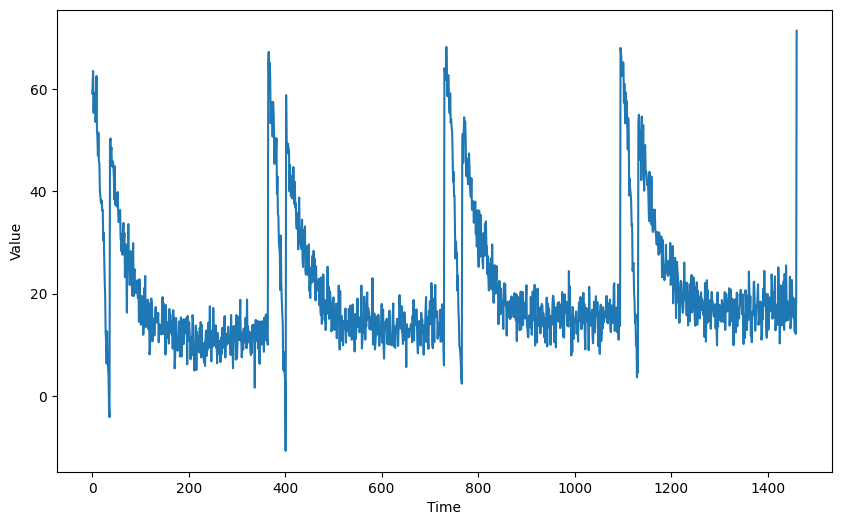

In [3]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)

    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [4]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [5]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Apply the transformation to the training set
dataset = windowed_dataset(series_train)

In [6]:
def create_uncompiled_model():

    ### START CODE HERE

    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[G.WINDOW_SIZE]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1),

        tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    ### END CODE HERE

    return model

In [7]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(dataset)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

34/34 [==============================] - 4s 32ms/step
Your current architecture is compatible with the windowed dataset! :)


In [8]:
def adjust_learning_rate():

    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))

    ### START CODE HERE

    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)


    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    ### END CODE HERE

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

    return history

In [9]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate()

Epoch 1/100
34/34 [==============================] - 11s 53ms/step - loss: 22.3404 - mae: 22.8367 - lr: 1.0000e-06
Epoch 2/100
34/34 [==============================] - 2s 62ms/step - loss: 7.0555 - mae: 7.5277 - lr: 1.1220e-06
Epoch 3/100
34/34 [==============================] - 1s 36ms/step - loss: 5.7955 - mae: 6.2648 - lr: 1.2589e-06
Epoch 4/100
34/34 [==============================] - 1s 35ms/step - loss: 5.3857 - mae: 5.8532 - lr: 1.4125e-06
Epoch 5/100
34/34 [==============================] - 2s 66ms/step - loss: 5.1643 - mae: 5.6299 - lr: 1.5849e-06
Epoch 6/100
34/34 [==============================] - 1s 35ms/step - loss: 5.0289 - mae: 5.4959 - lr: 1.7783e-06
Epoch 7/100
34/34 [==============================] - 2s 47ms/step - loss: 4.7499 - mae: 5.2165 - lr: 1.9953e-06
Epoch 8/100
34/34 [==============================] - 3s 78ms/step - loss: 4.5322 - mae: 4.9990 - lr: 2.2387e-06
Epoch 9/100
34/34 [==============================] - 3s 84ms/step - loss: 4.2941 - mae: 4.7604 - lr: 

(1e-06, 1.0, 0.0, 30.0)

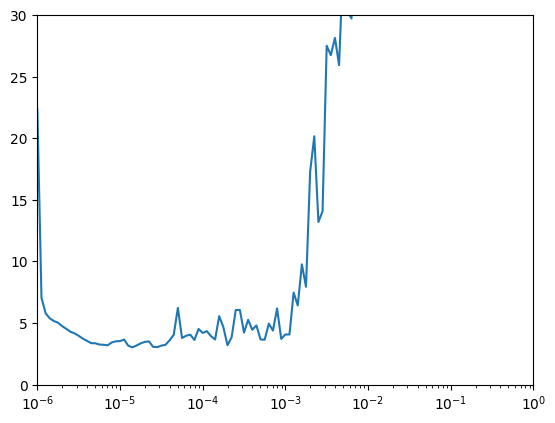

In [10]:
# Plot the loss for every LR
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-6, 1, 0, 30])

In [11]:
def create_model():

    tf.random.set_seed(51)

    model = create_uncompiled_model()

    ### START CODE HERE

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer='adam',
                  metrics=["mae"])

    ### END CODE HERE

    return model

In [12]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(dataset, epochs=50)

Epoch 1/50
34/34 [==============================] - 11s 35ms/step - loss: 8.6783 - mae: 9.1641
Epoch 2/50
34/34 [==============================] - 1s 38ms/step - loss: 3.6372 - mae: 4.1030
Epoch 3/50
34/34 [==============================] - 1s 35ms/step - loss: 3.3453 - mae: 3.8098
Epoch 4/50
34/34 [==============================] - 1s 39ms/step - loss: 3.1663 - mae: 3.6303
Epoch 5/50
34/34 [==============================] - 1s 40ms/step - loss: 3.1796 - mae: 3.6455
Epoch 6/50
34/34 [==============================] - 2s 67ms/step - loss: 2.8989 - mae: 3.3605
Epoch 7/50
34/34 [==============================] - 1s 35ms/step - loss: 2.7978 - mae: 3.2627
Epoch 8/50
34/34 [==============================] - 1s 37ms/step - loss: 2.7385 - mae: 3.2016
Epoch 9/50
34/34 [==============================] - 1s 38ms/step - loss: 3.1359 - mae: 3.5994
Epoch 10/50
34/34 [==============================] - 1s 34ms/step - loss: 3.1945 - mae: 3.6632
Epoch 11/50
34/34 [==============================] - 2s 45

In [13]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [14]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

46/46 [==============================] - 5s 19ms/step


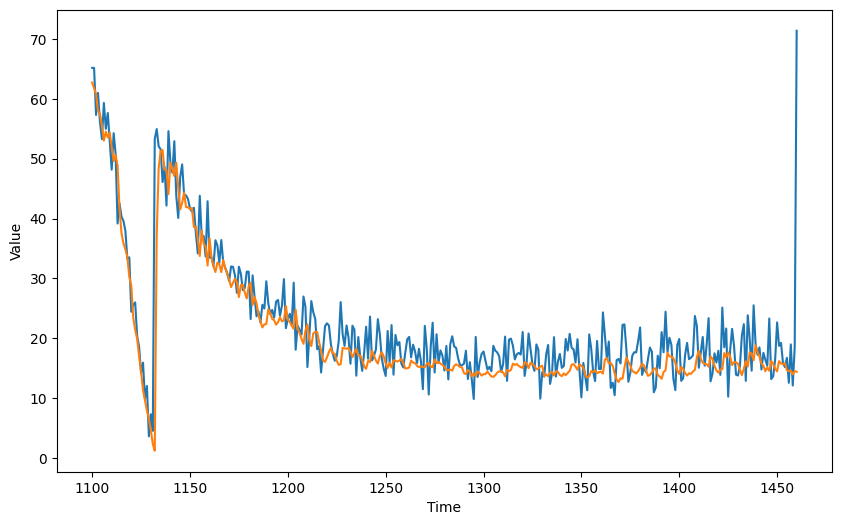

In [15]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot it
plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [16]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 32.33, mae: 3.37 for forecast


In [17]:
# Save your model in the SavedModel format
model.save('saved_model/my_model')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

saved_model/
saved_model/my_model/
saved_model/my_model/fingerprint.pb
saved_model/my_model/keras_metadata.pb
saved_model/my_model/assets/
saved_model/my_model/variables/
saved_model/my_model/variables/variables.data-00000-of-00001
saved_model/my_model/variables/variables.index
saved_model/my_model/saved_model.pb
